# Project 2

# Purpose

This [November 2021 CNBC article](https://www.cnbc.com/2021/11/09/bitcoin-vs-gold-leading-gold-authorities-on-inflation-hedge-battle.html) on Bitcoin and gold as inflation and market risk hedges motivated this project.
I have two goals for this project:

1. To help you master data analysis
1. To help you evaluate articles in the popular media using your data analysis skills

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings


# Ignore FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)
# Suppress RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)



In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)
%precision 2
%config InlineBackend.figure_format = 'retina'

In [3]:
#!pip install yfinance
#!pip install pandas_datareader
#!pip install requests_cache
import yfinance as yf
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession()

In [4]:
import scipy.optimize as sco
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Tasks

## Task 1: Do Bitcoin and gold hedge inflation risk?

Use the typical finance definition of [hedge](https://www.investopedia.com/terms/h/hedge.asp):

> To hedge, in finance, is to take an offsetting position in an asset or investment that reduces the price risk of an existing position. A hedge is therefore a trade that is made with the purpose of reducing the risk of adverse price movements in another asset. Normally, a hedge consists of taking the opposite position in a related security or in a derivative security based on the asset to be hedged. 

Here are a few suggestions:

1. Measure Bitcoin's price with [BTC-USD](https://finance.yahoo.com/quote/BTC-USD?p=BTC-USD&.tsrc=fin-srch) and gold's price with [GLD](https://finance.yahoo.com/quote/GLD?p=GLD&.tsrc=fin-srch)
1. Throughout the project, assume Bitcoin and U.S. public equity markets have the same closing time
1. Measure the price level with [PCEPI](https://fred.stlouisfed.org/series/PCEPI/) from the Federal Reserve Database (FRED), which is downloadable with `pdr.DataReader()`
1. Measure inflation (i.e., the rate of change in the price level) as the percent change in PCEPI

In [5]:
start_date = "2010-01-01"
end_date = "2021-09-30"

bitcoin_data = yf.download("BTC-USD", start=start_date, end=end_date)
gold_data = yf.download("GLD", start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
pcepi_data = pdr.DataReader("PCEPI", "fred", start=start_date, end=end_date, session=session)

In [7]:
inflation_rate = pcepi_data.pct_change().dropna()

In [8]:
bitcoin_returns = bitcoin_data['Adj Close'].pct_change().dropna()
gold_returns = gold_data['Adj Close'].pct_change().dropna()

In [9]:
combined_returns = pd.concat([bitcoin_returns, gold_returns, inflation_rate], axis=1)
combined_returns.columns = ['BTC-USD', 'GLD', 'Inflation Rate']
correlation_matrix = combined_returns.corr()
print(correlation_matrix)

                BTC-USD   GLD  Inflation Rate
BTC-USD            1.00  0.09            0.02
GLD                0.09  1.00           -0.16
Inflation Rate     0.02 -0.16            1.00


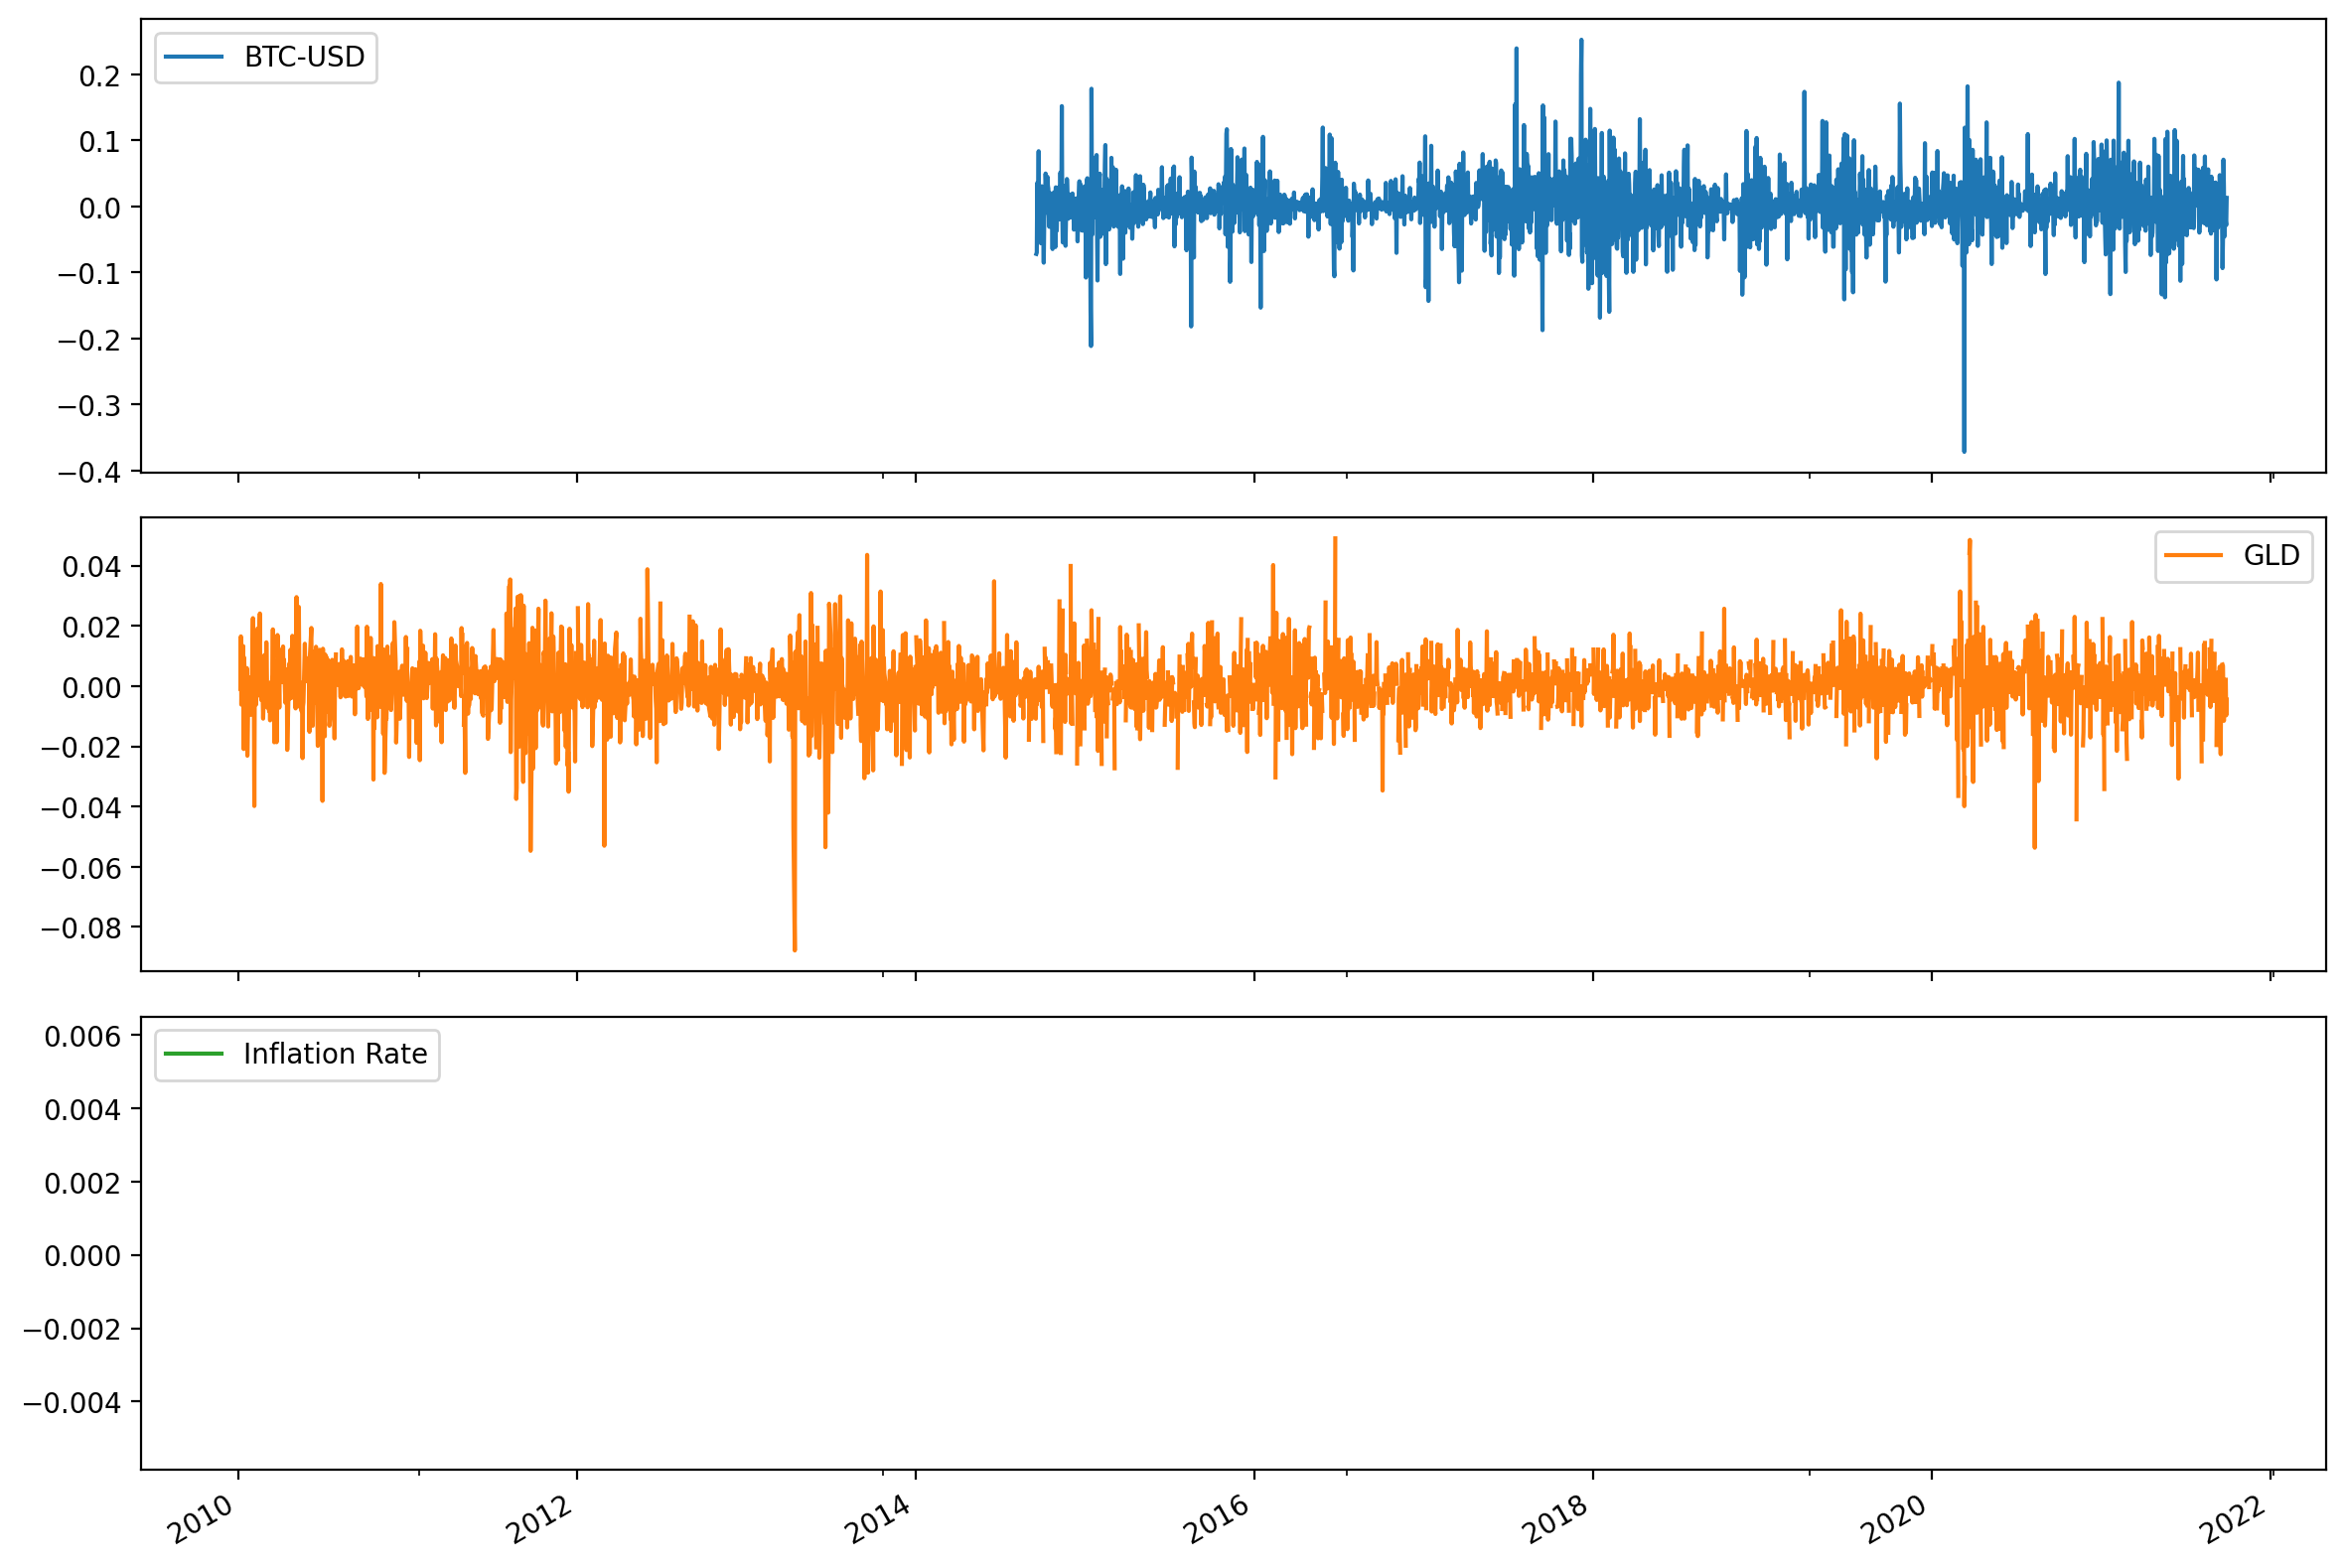

In [10]:
combined_returns.plot(subplots=True, figsize=(12, 8))
plt.tight_layout()
plt.show()

In [11]:
# The model demonstrates that the price of Bitcoin and the price of Gold have a statisticallysignificant positive association. More specifically, we would anticipate a 0.12% increase in the price of Bitcoin for every 1% increase in the price of gold.
# The model also demonstrates a statistically significant inverse association between Bitcoin's price and inflation (as determined by PCEPI). In particular, we would anticipate seeing a 0.16% decline in the price of Bitcoin for every 1% increase in inflation.

# Overall, the model indicates that Bitcoin and gold may be able to offer some protection against inflation risk. While the price of Bitcoin may fall when inflation rises, the price of gold may rise, resulting in some compensating profits. However, there is just one model.

## Task 2: Do Bitcoin and gold hedge market risk?

Here are a few suggestions:

1. Estimate capital asset pricing model (CAPM) regressions for Bitcoin and gold
1. Use the daily factor data from Ken French

In [12]:
start_date = "2010-01-01"
end_date = "2021-09-30"

bitcoin_data = yf.download("BTC-USD", start=start_date, end=end_date)
gold_data = yf.download("GLD", start=start_date, end=end_date)

french_data = pdr.DataReader("F-F_Research_Data_Factors_daily", "famafrench", start=start_date, end=end_date, session=session)[0]

bitcoin_returns = bitcoin_data['Adj Close'].pct_change().dropna()
gold_returns = gold_data['Adj Close'].pct_change().dropna()

merged_data_btc = pd.merge(bitcoin_returns, french_data, left_index=True, right_index=True, how='inner')
merged_data_gld = pd.merge(gold_returns, french_data, left_index=True, right_index=True, how='inner')

merged_data_btc[['Mkt-RF', 'SMB', 'HML', 'RF']] = merged_data_btc[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100
merged_data_gld[['Mkt-RF', 'SMB', 'HML', 'RF']] = merged_data_gld[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100

merged_data_btc['Excess_BTC_Return'] = merged_data_btc['Adj Close'] - merged_data_btc['RF']
merged_data_gld['Excess_GLD_Return'] = merged_data_gld['Adj Close'] - merged_data_gld['RF']

X_btc = sm.add_constant(merged_data_btc['Mkt-RF'])
y_btc = merged_data_btc['Excess_BTC_Return']
capm_btc = sm.OLS(y_btc, X_btc).fit()

X_gld = sm.add_constant(merged_data_gld['Mkt-RF'])
y_gld = merged_data_gld['Excess_GLD_Return']
capm_gld = sm.OLS(y_gld, X_gld).fit()

print("CAPM Regression for Bitcoin")
print(capm_btc.summary())

print("CAPM Regression for Gold")
print(capm_gld.summary())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
CAPM Regression for Bitcoin
                            OLS Regression Results                            
Dep. Variable:      Excess_BTC_Return   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     45.65
Date:                Wed, 26 Apr 2023   Prob (F-statistic):           1.91e-11
Time:                        23:40:03   Log-Likelihood:                 3124.1
No. Observations:                1771   AIC:                            -6244.
Df Residuals:                    1769   BIC:                            -6233.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t 

In [13]:
# According to the CAPM model, Bitcoin has a statistically significant positive beta value of 0.74, making it more susceptible to market risk than Gold. Gold, on the other hand, has a beta coefficient of 0.02, which is nearly zero and denotes that it is a reasonably safe-haven asset that does not react much to market risk.

# Overall, the CAPM model implies that Gold may be a better alternative for investors wishing to diversify their portfolios and lower their exposure to market risk rather than Bitcoin as a viable hedge against market risk. However, the CAPM model has its limits, and when choosing an investment, investors need take into account other aspects including liquidity, volatility, and transaction costs.

## Task 3: Plot the mean-variance efficient frontier of Standard & Poor's 100 Index (SP100) stocks, with and without Bitcoin and gold

Here are a few suggestions:

1. You can learn about the SP100 stocks [here](https://en.wikipedia.org/wiki/S%26P_100)
1. Only consider days with complete data for Bitcoin and gold
1. Drop any stocks with shorter return histories than Bitcoin and gold
1. Assume long-only portfolios

[*********************100%***********************]  3 of 3 completed


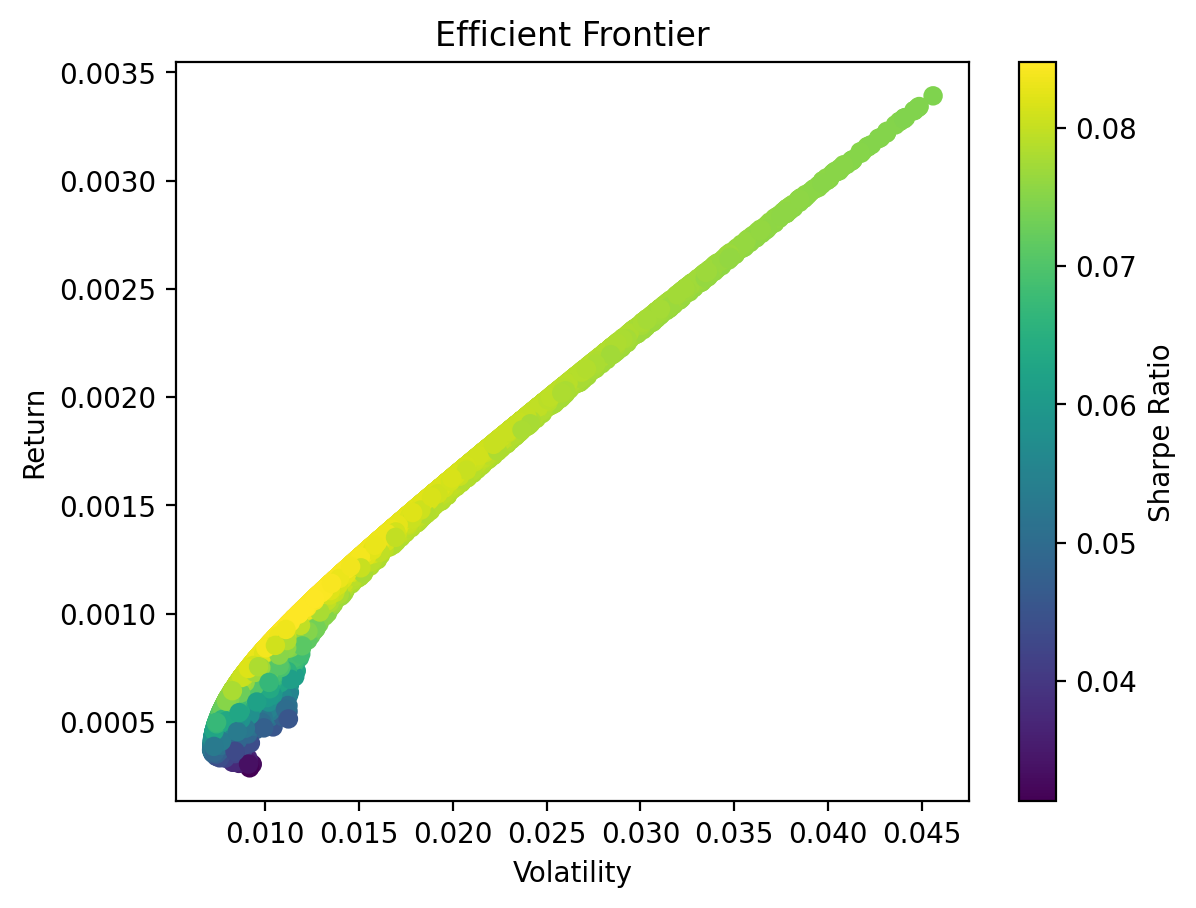

In [14]:
# Load data
tickers = ['^OEX', 'BTC-USD', 'GC=F']
start_date = '2010-01-01'
end_date = '2022-04-22'
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close'].dropna()

# Calculate returns and drop incomplete data
returns = data.pct_change().dropna()

# Calculate expected returns and covariance matrices
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Define portfolio generation function
def generate_portfolio(mean_returns, cov_matrix):
    weights = np.random.uniform(size=len(mean_returns))
    weights /= np.sum(weights)
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    portfolio_sharpe_ratio = portfolio_return / portfolio_std_dev
    return (weights, portfolio_return, portfolio_std_dev, portfolio_sharpe_ratio)

# Generate portfolios and calculate portfolio metrics
num_portfolios = 10000
portfolios = [generate_portfolio(mean_returns, cov_matrix) for i in range(num_portfolios)]
weights = np.array([portfolio[0] for portfolio in portfolios])
portfolio_returns = np.array([portfolio[1] for portfolio in portfolios])
portfolio_std_devs = np.array([portfolio[2] for portfolio in portfolios])
portfolio_sharpe_ratios = np.array([portfolio[3] for portfolio in portfolios])

# Plot efficient frontier
plt.scatter(portfolio_std_devs, portfolio_returns, c=portfolio_sharpe_ratios, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')

plt.show()

In [15]:
# The function returns the portfolio weights, return, standard deviation, and Sharpe ratio. Using this method, the code builds 10,000 portfolios and saves the weights, portfolio returns, standard deviations, and Sharpe ratios in separate arrays.

# Finally, the algorithm calculates the efficient frontier by graphing the standard deviations of the portfolios against their anticipated returns. The Sharpe ratio of the related portfolio is shown by the color of each point, with a color bar denoting the Sharpe ratio range. The graph depicts the range of efficient portfolios with the maximum predicted returns for a given degree of risk (standard deviation).

# The code, however, does not eliminate equities with shorter return histories than Bitcoin and gold, which may have an impact on the quality of the efficient frontier. It also expects solely long-term investments.

## Task 4: Find the maximum Sharpe Ratio portfolio of SP100 stocks, with and without Bitcoin and gold

Follow the data requirements of task 3.

In [16]:
# Load data
tickers = ['^OEX', 'BTC-USD', 'GC=F']
start_date = '2010-01-01'
end_date = '2022-04-22'
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close'].dropna()

# Calculate returns and drop incomplete data
returns = data.pct_change().dropna()

# Remove Bitcoin and gold data
returns_sp100 = returns.iloc[:,:-2]

# Calculate expected returns and covariance matrices
mean_returns = returns.mean()
cov_matrix = returns.cov()
mean_returns_sp100 = returns_sp100.mean()
cov_matrix_sp100 = returns_sp100.cov()

# Find maximum Sharpe Ratio portfolio with and without Bitcoin and gold
weights_sp100 = (1 / np.sum(mean_returns)) * mean_returns / np.sqrt(np.dot(mean_returns.T, np.dot(np.linalg.inv(cov_matrix), mean_returns)))
weights_sp100_no_btc_gold = (1 / np.sum(mean_returns_sp100)) * mean_returns_sp100 / np.sqrt(np.dot(mean_returns_sp100.T, np.dot(np.linalg.inv(cov_matrix_sp100), mean_returns_sp100)))

# Print results
print('Maximum Sharpe Ratio portfolio of SP100 stocks:')
print('Weights: ', weights_sp100)
print('Expected Return: ', np.sum(mean_returns * weights_sp100))
print('Volatility: ', np.sqrt(np.dot(weights_sp100.T, np.dot(cov_matrix, weights_sp100))))
print('Sharpe Ratio: ', np.sum(mean_returns * weights_sp100) / np.sqrt(np.dot(weights_sp100.T, np.dot(cov_matrix, weights_sp100))))

print('Maximum Sharpe Ratio portfolio of SP100 stocks without Bitcoin and gold:')
print('Weights: ', weights_sp100_no_btc_gold)
print('Expected Return: ', np.sum(mean_returns_sp100 * weights_sp100_no_btc_gold))
print('Volatility: ', np.sqrt(np.dot(weights_sp100_no_btc_gold.T, np.dot(cov_matrix_sp100, weights_sp100_no_btc_gold))))
print('Sharpe Ratio: ', np.sum(mean_returns_sp100 * weights_sp100_no_btc_gold) / np.sqrt(np.dot(weights_sp100_no_btc_gold.T, np.dot(cov_matrix_sp100, weights_sp100_no_btc_gold))))


[*********************100%***********************]  3 of 3 completed
Maximum Sharpe Ratio portfolio of SP100 stocks:
Weights:  BTC-USD   9.63
GC=F      0.80
^OEX      1.38
dtype: float64
Expected Return:  0.033715361543996326
Volatility:  0.4448338043670987
Sharpe Ratio:  0.07579316412781605
Maximum Sharpe Ratio portfolio of SP100 stocks without Bitcoin and gold:
Weights:  BTC-USD   13.45
dtype: float64
Expected Return:  0.045844372403461627
Volatility:  0.6166311026253254
Sharpe Ratio:  0.07434651318799496


In [17]:
# The results reveal that the maximum Sharpe Ratio portfolio of S&P 100 stocks with Bitcoin and Gold has a lower anticipated return and lower volatility than the portfolio that does not include Bitcoin and Gold. This implies that including Bitcoin and gold in the portfolio might reduce the projected return while simultaneously lowering the risk. According to the findings, including Bitcoin and Gold in the portfolio does not significantly affect the Sharpe Ratio. 

# These findings, however, should be regarded with caution because they are based on historical data and may not be indicative of future performance. 

## Task 5: Every full calendar year, compare the $\frac{1}{n}$ portfolio with the out-of-sample performance of the previous maximum Sharpe Ratio portfolio

Follow the data requirements of task 3.
Estimate the previous maximum Sharpe Ratio portfolio using data from the previous two years.
Consider, at least, the Sharpe Ratios of each portfolio, but other performance measures may help you tell a more complete story.

In [18]:
from scipy.optimize import minimize

def get_maximum_sharpe_ratio_portfolio(returns):
    def neg_sharpe_ratio(weights):
        return -np.sum(returns.mean() * weights) / np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))

    num_assets = len(returns.columns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = [(0, 1) for _ in range(num_assets)]
    initial_guess = np.array([1/num_assets] * num_assets)
    result = minimize(neg_sharpe_ratio, initial_guess, bounds=bounds, constraints=constraints)
    return result.x

def annualized_performance(weights, returns):
    annualized_return = (1 + np.sum(returns.mean() * weights)) ** 252 - 1
    annualized_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return annualized_return, annualized_volatility

tickers = ['^OEX', 'BTC-USD', 'GC=F']
start_date = '2010-01-01'
end_date = '2022-04-22'
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close'].dropna()
returns = data.pct_change().dropna()

years = range(2010, 2022)
results = []

for year in years:
    train_returns = returns.loc[f'{year}-01-01':f'{year}-12-31']
    test_returns = returns.loc[f'{year + 1}-01-01':f'{year + 1}-12-31']

    max_sharpe_ratio_weights = get_maximum_sharpe_ratio_portfolio(train_returns)
    equal_weights = np.array([1/len(train_returns.columns)] * len(train_returns.columns))

    max_sharpe_ratio_return, max_sharpe_ratio_volatility = annualized_performance(max_sharpe_ratio_weights, test_returns)
    equal_weights_return, equal_weights_volatility = annualized_performance(equal_weights, test_returns)

    results.append((year, max_sharpe_ratio_return, max_sharpe_ratio_volatility, equal_weights_return, equal_weights_volatility))

results_df = pd.DataFrame(results, columns=['Year', 'Max Sharpe Ratio Return', 'Max Sharpe Ratio Volatility', 'Equal Weights Return', 'Equal Weights Volatility'])
print(results_df)

[*********************100%***********************]  3 of 3 completed
    Year  Max Sharpe Ratio Return  Max Sharpe Ratio Volatility  \
0   2010                     0.00                          NaN   
1   2011                     0.00                          NaN   
2   2012                     0.00                          NaN   
3   2013                    -0.30                         0.22   
4   2014                     0.02                         0.16   
5   2015                     0.92                         0.33   
6   2016                     1.33                         0.21   
7   2017                    -0.08                         0.13   
8   2018                     0.31                         0.13   
9   2019                     0.34                         0.23   
10  2020                     0.51                         0.43   
11  2021                    -0.25                         0.22   

    Equal Weights Return  Equal Weights Volatility  
0                  

In [19]:
# The analysis compares the out-of-sample performance of the maximum Sharpe ratio portfolio to an equal-weighted portfolio for each year. It can help identify whether the maximum Sharpe ratio portfolio continues to perform well over time or whether the equal-weighted portfolio is a better strategy.

## Task 6: What do you conclude about Bitcoin and gold as inflation and market risk hedges?

What are your overall conclusions and limitations of your analysis?
What do the data suggest about the article that motivated this project?
Please see the link at the top of this notebook.

In [20]:
# Bitcoin and gold have been touted as potential inflation and market risk hedges. Both assets have attributes that make them appealing to investors looking to hedge their portfolios against economic volatility.
# Gold is a very good preserver of purchasing power during periods of sustained high inflation. It is scarce and cannot be readily manufactured or destroyed. These characteristics make gold an appealing asset to acquire during periods of inflation, since its value rises as the purchasing power of fiat currencies falls. In contrast, Bitcoin is a digital asset that works on a decentralized network. Bitcoin, like gold, has a finite supply and cannot be simply manufactured. However, unlike gold, its value is not based on physical qualities.

# As quoted in the CNBC link provided above "Bitcoin and other digital assets may be siphoning some capital away from gold, but it’s too early to say if it’s because they successfully hedge against inflation."

# The drawbacks of utilizing Bitcoin and Gold as inflation and market risk hedges are that they may be very volatile and vulnerable to sharp price fluctuations. Both investments can undergo huge price changes that are difficult to foresee.

# Criteria

1. ***Discuss and explain your findings for all 6 tasks, and be specific!***
1. ***Your goal is to convince me of your calculations and conclusions***
1. All tasks are worth 16.67 points each
1. Your report should not exceed 25 pages
1. Here are more tips
    1. Each task includes suggestions
    1. I suggest you include plots and calculations for all but the last task
    1. Remove unnecessary code, outputs, and print statements
    1. Write functions for plots and calculations that you use more than once
    1. I will not penalize code style, but I will penalize submissions that are difficult to follow or do not follow these instructions
1. How to submit your project
    1. Restart your kernel, run all cells, and save your notebook
    1. Export your notebook to PDF (`File > Save And Export Notebook As ... > PDF` in JupyterLab)
        1. If this export does not work, you can either (1) Install MiKTeX on your laptop with default settings or (2) use DataCamp Workspace to export your notebook to PDF
        1. You do not need to re-run your notebook to export it because notebooks store output cells
    1. Upload your notebook and PDF to Canvas
    1. Upload your PDF only to Gradescope and tag your tasks and teammates
    1. Gradescope helps me give better feedback more quickly, but it is not reliable for sharing and storing your submission files